# Baseline

In [ ]:
# Enable interactive plot
%matplotlib notebook

import argparse 
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.animation as animation 
from IPython.display import HTML


#set animation update interval
updateInterval = 50

#set simulation parameters
nMajority = 1250
nMinority = 250
#fracHappy = 0.3
gridSize = 50
  
class Agent:
    def __init__(self, r=1, i=0, j=0):
       self.race = r
       self.goal = 0.4
       self.unhappy = False
       if (self.race==1):
           self.color = 0.5
       elif (self.race==2): 
           self.color = 1.0
       else:
           self.color = 0.0
       self.i = i
       self.j = j
           
def initAgents(a,nMajority,nMinority):
    for _ in range(nMajority):
        a.append(Agent(1))
    for _ in range(nMinority):
        a.append(Agent(2))
    return a

def placeAgents(agents,grid,gridSize,nMajority,nMinority):
    for _,agent in enumerate(agents):
        i = np.random.randint(1,gridSize+1,1)
        j = np.random.randint(1,gridSize+1,1)
        while (grid[i,j] != 0):
            i = np.random.randint(1,gridSize+1,1)
            j = np.random.randint(1,gridSize+1,1)
        agent.i = i
        agent.j = j
        grid[i,j] = agent.color
    return [agents,grid]

def checkHappy(agents,grid,nMajority,nMinority):
#def checkHappy(agents,grid,nMajority,nMinority,fracHappy):
    uha = []
    numberUnhappy = 0
    for _,agent in enumerate(agents):
        nSame = 0
        nDifferent = 0
        i = agent.i
        j = agent.j
        for m in range(int(i-1),int(i+2)):
            for n in range(int(j-1),int(j+2)):
                if (grid[m,n]==agent.color):
                    nSame=nSame+1
                elif(grid[m,n]!=0.0):
                    nDifferent = nDifferent+1
        nSame = nSame - 1
        if(nSame+nDifferent == 0):
            agent.unhappy = False
        elif(agent.goal >=(((nSame)/(nSame+nDifferent)))):
        #elif(fracHappy>=(((nSame)/(nSame+nDifferent)))):
            agent.unhappy = True
            numberUnhappy = numberUnhappy + 1
        else:
            agent.unhappy = False
    # print(numberUnhappy)
    return uha, numberUnhappy

def update(frameNum, img, grid, nMajority, nMinority, gridSize, agents): 
  
    # copy grid since we require 8 neighbors  
    # for calculation and we go line by line  
    newGrid = np.zeros([gridSize+2,gridSize+2]) 
    zeros = np.argwhere(grid[1:gridSize,1:gridSize]==0)
    for _,agent in enumerate(agents):
        if(agent.unhappy):
            o = np.random.randint(0,len(zeros))
            i = zeros[o][0]
            j = zeros[o][1]
            np.delete(zeros,o)
            grid[i,j] = agent.color
            agent.i = i
            agent.j = j
        newGrid[agent.i,agent.j] = agent.color
        
    # check for unhappy agents
    _,n = checkHappy(agents,newGrid,nMajority,nMinority)
    # update data 
    img.set_data(newGrid) 
    grid[:] = newGrid[:] 

    x.append(frameNum)
    y.append(n)
    line.set_data(x,y)
    return img, line,
  
#initialize grid
grid = np.zeros([gridSize+2,gridSize+2])

#instantiate agents
agents = []
agents = initAgents(agents,nMajority,nMinority)

#place agents
[agents,grid]= placeAgents(agents,grid,gridSize,nMajority,nMinority)
           
# set up animation 
x,y =[],[]
fig, (ax1,ax2) = plt.subplots(1,2) 
img = ax1.imshow(grid, interpolation='nearest') 
line, = ax2.plot([], [], lw=3)
ax2.set(xlim=(0,50), ylim=(0,200), aspect='0.25')
ani = animation.FuncAnimation(fig, update, fargs=(img, grid, nMajority, nMinority, gridSize, agents), 
                              frames = 50, 
                              interval=updateInterval, 
                              save_count=50) 

plt.show() 
HTML(ani.to_jshtml())


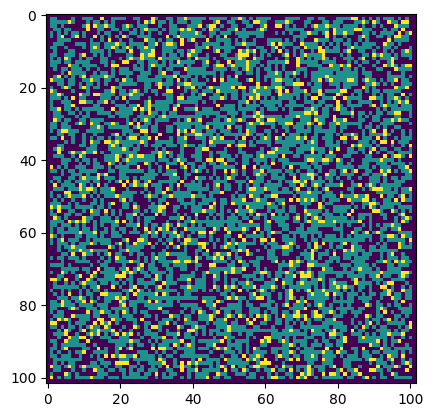

In [31]:
# -*- coding: utf-8 -*-
"""
@author: Hosley
"""
import numpy as np 
import matplotlib.pyplot as plt  
import matplotlib.animation as animation 
# Uncomment to display in .ipynb
from IPython.display import HTML

#set animation update interval
updateInterval = 50

#set simulation parameters
nMajority = 5000
nMinority = 1000
gridSize = 100
  
class Agent:
    def __init__(self, r=1, g=0.3, i=0, j=0):
       self.team = r
       self.goal = g
       self.unhappy = False
       if (self.team==1):
           self.color = 0.5
       elif (self.team==2): 
           self.color = 1.0
       else:
           self.color = 0.0
       self.i = i
       self.j = j
           
def initAgents(a,nMajority,nMinority):
    for _ in range(nMajority):
        a.append(Agent(1))
    for _ in range(nMinority):
        a.append(Agent(2))
    return a

def placeAgents(agents,grid,gridSize,):
    open = np.argwhere(grid[1:gridSize+1,1:gridSize+1]==0)
    for agent in agents:
        # select a random opening and move
        o = np.random.randint(0,len(open))
        i = open[o][0]+1    # index correction
        j = open[o][1]+1    # from argwhere shift
        agent.i = i
        agent.j = j
        grid[i,j] = agent.color
        # remove opening from list
        open = np.delete(open,o,0)
    return [agents,grid]

def checkHappy(agents,grid):
    uha = []
    numberUnhappy = 0
    for agent in agents:
        nSame = 0
        nDifferent = 0
        i = agent.i
        j = agent.j
        for m in range(int(i-1),int(i+2)):
            for n in range(int(j-1),int(j+2)):
                if (grid[m,n]==agent.color):
                    nSame=nSame+1
                elif(grid[m,n]!=0.0):
                    nDifferent = nDifferent+1
        # correct for self counting
        nSame = nSame - 1
        nBoth = nSame + nDifferent
        if(nBoth == 0):
            agent.unhappy = False
        elif(agent.goal >=(((nSame)/(nBoth)))):
            agent.unhappy = True
            numberUnhappy = numberUnhappy + 1
        else:
            agent.unhappy = False
    return uha, numberUnhappy
                
def update(frameNum, img, grid, gridSize, agents): 
  
    # copy grid since we require 8 neighbors  
    # for calculation and we go line by line  
    newGrid = np.zeros([gridSize+2,gridSize+2]) 
    # find the list of open cells
    open = np.argwhere(grid[1:gridSize+1,1:gridSize+1]==0)
    for agent in agents:
        if(agent.unhappy):
            # select a random opening and move
            o = np.random.randint(0,len(open))
            i = open[o][0]+1    # index correction
            j = open[o][1]+1    # from argwhere shift
            agent.i = i
            agent.j = j
            # delete the opening from list
            open = np.delete(open,o,0)
        newGrid[agent.i,agent.j] = agent.color
        
    # check for unhappy agents
    _,n = checkHappy(agents,newGrid)
    # update data 
    img.set_data(newGrid) 
    grid[:] = newGrid[:] 

    x.append(frameNum)
    y.append(n)
    line.set_data(x,y)
    return img, line
  
#initialize grid
grid = np.zeros([gridSize+2,gridSize+2])

#instantiate agents
agents = []
agents = initAgents(agents,nMajority,nMinority)

#place agents
[agents,grid]= placeAgents(agents,grid,gridSize)
           
# set up animation 
x,y =[],[]
fig, (ax1,ax2) = plt.subplots(1,2) 
img = ax1.imshow(grid, interpolation='nearest') 
line, = ax2.plot([], [], lw=3)
ax2.set(xlim=(0,50), ylim=(0,200), aspect='0.25')
ani = animation.FuncAnimation(fig, update, fargs=(img, grid,gridSize, agents, ), 
                              frames = 50, 
                              interval=updateInterval, 
                              save_count=50) 
  
plt.show() 

# uncomment to display in .ipynb
HTML(ani.to_jshtml())